<a href="https://colab.research.google.com/github/Guillem96/playing-with-word-embeddings/blob/master/playing-word-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playing with embeddings 

This article covers the most used text preprocessing technique used to convert text into numbers, so the text sentences can be feed to Machine Learning (ML) and Deep Learning (DL) models.

Intelligent models don't take as input raw text, they only work with numeric data. *Vectorizing* text is the process of transforming text into numeric tensors.

There are different ways to vectorize raw text. The top three popular vectorizing methods are:

- Segment text into words, and transform each word into a vector.
- Segment text into characters, and transform each character into a vector.
- Extract n-grams of words or characters, and transform each n-gram into a vector.
 *N-grams* are overlapping groups of multiple consecutive words or characters. [[1]](#references)

The different units which a sentence is split into, are called *tokens*. 

> Note: All *vectorizing* methods consist of first *tokenizing* the sentence (Split a sentence into different units) and then associating a vector to each *token*.

First, we will introduce *one-hot encoding (OHE)* and then we are going to dive into *word embeddings*, which is the most used word-level *vectorization* mehtod among the DL community.

> Note: Some advanced methods, such as pretrained Transformers (BERT[[2]](#references), RoBERTa[[3]](#references), ...) use *n-grams* level tokenization. That is because n-grams tokenization can efficiently handle with huge vocabularies.

![Vectorization](https://freecontent.manning.com/wp-content/uploads/Chollet_DLfT_01.png)

## One-hot Encoding (OHE)

OHE is the most basic way to convert a token into a vector. It consists of associating a unique integer index with every word and then turning this integer index *i* into a binary vector of size N (the size of the vocabulary); the vector is all zeros except for the *i* th entry, which is 1. [[1]](#references)

We can use scikit-learn(sklearn) to convert tokens into vectors using OHE. To do so, sklearn provides a OneHotEncoder class, which like all the other sklearn classes, has a `fit` and `transform` method. These methods do the following tasks:

- `fit`: Learns the vocabulary of our dataset, and learns how to associate a token with an integer index.
- `transform`: Accordingly with the understanding acquired in the `fit` method transforms each token to its associated vector.

In [0]:
import numpy as np
# Import ohe class
from sklearn.preprocessing import OneHotEncoder

# Declare text examples
texts = ['I study Computer Science at university',
         'My dog is called Peludet']

As we explained on the introduction first we need to tokenize the texts. We will be working with a word-level tokenization, so we are going to split sentences by `' '` character.

In [3]:
# Split texts by ' '
tokenized_texts = [text.split() for text in texts]
tokenized_texts

[['I', 'study', 'Computer', 'Science', 'at', 'university'],
 ['My', 'dog', 'is', 'called', 'Peludet']]

In [4]:
# Flat the texts list so the tokens are ina single list
tokenized_texts = [[t] for tokens in tokenized_texts for t in tokens]
tokenized_texts

[['I'],
 ['study'],
 ['Computer'],
 ['Science'],
 ['at'],
 ['university'],
 ['My'],
 ['dog'],
 ['is'],
 ['called'],
 ['Peludet']]

Now we are ready to feed the tokens to sklearn `OneHotEncoder` class `fit` method.


In [5]:
# Create OneHotEncoder instance
ohe = OneHotEncoder()

# Feed the tokens to fit method
ohe.fit(tokenized_texts)

# See what out OneHotEncoder has learned
print('Vocabulary:', ohe.get_feature_names())
print('Vocabulary len:', len(ohe.get_feature_names()))

Vocabulary: ['x0_Computer' 'x0_I' 'x0_My' 'x0_Peludet' 'x0_Science' 'x0_at'
 'x0_called' 'x0_dog' 'x0_is' 'x0_study' 'x0_university']
Vocabulary len: 11


In [6]:
texts[0].split()

['I', 'study', 'Computer', 'Science', 'at', 'university']

In [7]:
# Now we can covert out tokens to vectors
## For a more clear example we will only vectorize first sentence
encoded_sentence = ohe.transform(np.array(texts[0].split()).reshape(-1, 1))
for t, v in zip(texts[0].split(), encoded_sentence):
  print('Token: {} -> Vector: {}'.format(t, v.toarray()))

Token: I -> Vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Token: study -> Vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Token: Computer -> Vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Token: Science -> Vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Token: at -> Vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Token: university -> Vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


As we can see each token is associated with an integer value *i*, which corresponds to the array *i*th position which at the time is set to 1.

![One Hot Encoding](https://raw.githubusercontent.com/tensorflow/docs/r2.0rc/site/en/r2/tutorials/text/images/one-hot.png)

**Even though OHE is simple, it is inefficient**. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

Now imagine that we are trying to vectorize these three words:

- great
- good
- bad

If we vectorize them using OHE we will get this result:

```python
assert good  == [1, 0, 0]
assert great == [0, 1, 0]
assert bad   == [0, 0, 1]
```

In this case, OHE vectorization result is telling us that `good` is as different as `great` and `bad`. So we need another vectorization method that can handle semantic similarities, here is where **Word Embeddings** is important.

## Word Embeddings

A more powerful way to convert tokens into vectors is the use of *dense vectors*. Those dense vectors are tokens' representations in which similar words have similar vectors. More precisely, we call those vectors *embeddings*

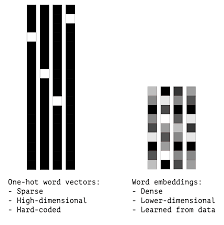

Embeddings are more useful when our problem involves a hughe vocabulary. As we have seen before, OHE needs vectors of size N to encode words belonging to a vocabulary of N tokens, whearas with Word Embedding we can use a fixed size to encode a vocabulary of N tokens. It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies. So, word embeddings pack more information into ar fewer dimensions.

Hopefully, we don't have to think a way to fill those M-dimentional dense vectors manually. Usually embeddings are obtained via two possibilities.

1. Learn word embeddings joinly with the main task we care about. So in this case embeddings are an extra layer on our neural netwiork that their weights are updated during backpropagation jointly with the task we are trying to solve, for example sentiment analysis. See [this tutorial](https://www.tensorflow.org/beta/tutorials/text/word_embeddings) to learn how to train word embeddings from scratch.

2. Load into a matrix word embedding that were precomputed using a different machine-learning task. These are called pretrained *word embeddings*.

In this article we will focus on the second way of obtaining wrd embeddings. More precisely we are going to use GloVe embeddings [[4](#references)]. We are going to explore the embeddings learned from 6Billion tokens of text from Wikipedia.

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

### Playing with pretrained embeddings

First, we have to download the embeddings

In [8]:
%%shell

wget http://nlp.stanford.edu/data/glove.6B.zip
unzip /content/glove.6B.zip

--2019-09-11 14:46:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-09-11 14:46:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-09-11 14:46:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.4’

glove

We will be using the 300-dimensional embeddings. 

GloVe embeddings come in txt files where each row contains a token and its embedding.

In [0]:
# Dict
# key -> the token (word)
# value -> word embedding
embeddings = {}
with open('glove.6B.300d.txt') as f:
  embeddings = {l.split()[0]: np.array(l.split()[1:]).astype('float') for l in f}

To understand better how we organize the embeddings we will print the first 5 word embeddings

In [10]:
for i, (k, v) in enumerate(embeddings.items()):
  print('{} -> {}...'.format(k, v[:5]))
  if i == 5:
    break

the -> [ 0.04656    0.21318   -0.0074364 -0.45854   -0.035639 ]...
, -> [-0.25539  -0.25723   0.13169  -0.042688  0.21817 ]...
. -> [-0.12559   0.01363   0.10306  -0.10123   0.098128]...
of -> [-0.076947 -0.021211  0.21271  -0.72232  -0.13988 ]...
to -> [-0.25756  -0.057132 -0.6719   -0.38082  -0.36421 ]...
and -> [ 0.038466 -0.039792  0.082747 -0.38923  -0.21431 ]...


### The First experiment - Get closest embeddings

First, we define a function that will help us to get the top k similar embeddings to a word. 

Try to understand this function because it will be crucial with the following experiments.

In [0]:
def get_closest(x, top_k=3):
  """
  Get the closest embeddings

  Parameters
  ----------
  x: np.ndarray
    Vector containing an embedding
  top_k: int, optional
    Get the top k similar embeddings

  Returns
  -------
  dict
    Dict containing the top k similar embeddings to the given x
  """
  # Stack all embeddings in a single matrix. Note: the matrix dimention will be
  # V x D where V is the vocabulary size and D is the embedding dimension
  embedding_matrix = np.array(list(embeddings.values()))
  # Using broadcasting compute distance to each embedding in our vocabulary
  distances = x - embedding_matrix
  # Comoute the magnitude of each distance
  distances = np.linalg.norm(distances, axis=1)
  # Sort distance and keep the smallest k
  min_idx = np.argsort(distances)[:top_k]
  return {list(embeddings.keys())[i]: embedding_matrix[i] for i in min_idx}

Now we are going to try to retrieve the top 5 similar embeddings near to the token `dog`.

In [12]:
similar_animal = get_closest(embeddings['dog'], top_k=5)
list(similar_animal.keys())

['dog', 'dogs', 'cat', 'pet', 'puppy']

Wow! Our embeddings know what a dog may look like. As we see, embeddings encode a lot of interesting features. For example, in this case, `dog` is very related to `dogs` (which is its plural), `cat` (which is another `pet`) and also to `puppy` (little dog).

Fortunately, we can plot those similarities in a 2D space to then better visualize them.

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition  import PCA

def plot_embeddings(embeddings, names):
  # To reduce embedding dims without losing much information we use PCA
  tsne = PCA(n_components=2)
  Y = tsne.fit_transform(np.array([embeddings[k] for k in names]))

  x_coords = Y[:, 0]
  y_coords = Y[:, 1]

  plt.scatter(x_coords, y_coords)
  for label, x, y in zip(names, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
  
  plt.xlim(x_coords.min() - 2, x_coords.max() + 2)
  plt.ylim(y_coords.min() - 2, y_coords.max() + 2)
  plt.show()

Now we will try to plot the embeddings similar to `dog` and embeddings similar to `city`. This way we will be able to see two clusters of embeddings, one cluster for tokens near to dog and another cluster for tokens of cities and countries. 

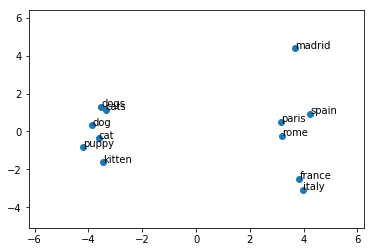

In [59]:
to_plot = ['dog', 'dogs', 'cat', 'cats', 'puppy', 'kitten',
            'madrid', 'spain','france', 'paris', 'italy', 'rome']

plot_embeddings(embeddings, to_plot)

Interesting, isn't it? Now, we have seen that embeddings encode word semantics and therfore we can use it to get words with similar meanings. That is important for deep learning tasks such as sentiment analysis, document classification, topic extraction, etc. 

Interestingly, when we train word embeddings from scratch for a sentiment analysis task, we end up learning embeddings that their representation is composed of two clusters.
1. one cluster for positive tokens
2. and another for negative tokens.
 
We can see this phenomenon in the following image.

<img src=" 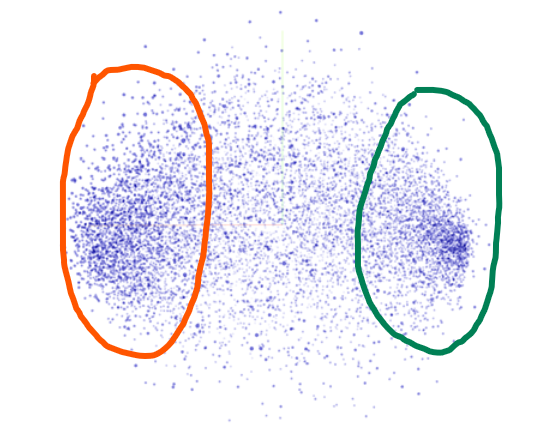">


## References
 <a id="references"></a>
- [1] Deep Learning with Python - François Chollet <a id="ref-1"></a>
- [2] BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - https://arxiv.org/abs/1810.04805

- [3] RoBERTa: An optimized method for pretraining self-supervised NLP systems - https://arxiv.org/abs/1907.11692
- [4] GloVe: Global Vectors for Word Representation - https://nlp.stanford.edu/projects/glove/